In [1]:

from numpy import random
import torch
import torchvision
from torch.nn import functional as F
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
import cv2
import os
import tensorflow as tf
from tensorflow import keras
import scipy.stats as sci 

2023-07-14 05:54:13.780359: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-14 05:54:17.730167: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /scratch/shkulkar/python/lib/python3.8/site-packages/cv2/../../lib64:/usr/local/cuda-11.3/lib64:/scratch/shkulkar/python/lib:/usr/local/cuda-11.3/tensorRT-8.0/lib64:/usr/local/cuda-11.3/cudnn-8.2/lib64:/usr/local/cuda-11.3/nccl-2.9/lib64
2023-07-14 05:54:17.730525: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.

In [2]:
import os

os.environ['HTTP_PROXY'] = 'http://fp.cs.ovgu.de:3210/'
os.environ['HTTPS_PROXY'] = 'http://fp.cs.ovgu.de:3210/'

# !git clone https://github.com/yiskw713/ScoreCAM.git

In [3]:
%cd /project/validating_attribution_techniques/commons/ScoreCAM

/project/validating_attribution_techniques/commons/ScoreCAM


In [4]:
!nvidia-smi

Fri Jul 14 05:54:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:B1:00.0 Off |                  N/A |
| 22%   24C    P8     4W / 250W |      1MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:B2:00.0 Off |                  N/A |
| 22%   

In [5]:
os.environ['CUDA_VISIBLE_DEVICES'] = "2,3"
ngpu = torch.cuda.device_count()
for gpu_id in range(ngpu):
    gpu = torch.cuda.get_device_name(gpu_id)
    print(f"GPU:{gpu_id} {gpu}")

GPU:0 NVIDIA GeForce RTX 2080 Ti
GPU:1 NVIDIA GeForce RTX 2080 Ti


In [6]:
%matplotlib inline

import numpy as np
import skimage.transform
import torch
import torch.nn as nn
import torch.nn.functional as F
# from ScoreCAM import cam

from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torchvision.utils import save_image

from cam import CAM, GradCAM, GradCAMpp, SmoothGradCAMpp, ScoreCAM
from utils.visualize import visualize, reverse_normalize
from utils.imagenet_labels import label2idx, idx2label

from scipy.spatial.distance import cdist
from pyemd import emd


# Loading Original Image

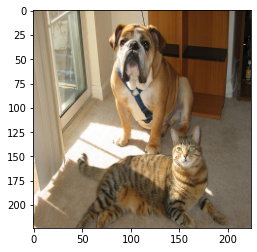

In [7]:
image = Image.open('/project/validating_attribution_techniques/commons/examples/input.png')
# image = keras.utils.get_file("cat_and_dog.jpg", "https://storage.googleapis.com/petbacker/images/blog/2017/dog-and-cat-cover.jpg",)
imshow(image)

# Preprocessing Image

In [8]:
def preprocessing(image):
    # Resize the image
    size = (300, 300)
    image = image.resize(size)
    
    # preprocessing. mean and std from ImageNet
    normalize = transforms.Normalize(
       mean=[0.485, 0.456, 0.406],
       std=[0.229, 0.224, 0.225]
    )

    preprocess = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])

    # convert image to tensor
    tensor = preprocess(image)

    # reshape 4D tensor (N, C, H, W)
    tensor = tensor.unsqueeze(0)
    
    return tensor

In [9]:
tensor = preprocessing(image)
tensor.shape

torch.Size([1, 3, 300, 300])

In [10]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True).to(device)
model.eval()

Using cache found in /home/shkulkar/.cache/torch/hub/pytorch_vision_v0.10.0
/scratch/shkulkar/python/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/scratch/shkulkar/python/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
gpu_reference_tensor = next(model.parameters())
tensor = tensor.type_as(gpu_reference_tensor)

# Model Target layer

In [12]:
target_layer = model.layer4[1].conv2

In [13]:
classes = open("/project/validating_attribution_techniques/shardul/classes.txt").read().splitlines()

# Attribution Technique Function: ScoreCAM

In [14]:
def scoreCAM(target_layer, model, tensor):
    wrapped_model = ScoreCAM(model, target_layer)
    cam, idx = wrapped_model(tensor)
    return cam, idx

# Saliency Map Generation Function

In [15]:
def saliency_map(tensor, cam):
#     tensor = tensor.cpu()
    img = reverse_normalize(tensor)
    heatmap = visualize(img, cam)
    heatmap = np.transpose(heatmap.squeeze(), (1, 2, 0))
    return heatmap

# ScoreCAM on Original Image

In [16]:
cam, idx = scoreCAM(target_layer, model, tensor)
cam = cam.cpu()

Text(0.5, 1.0, 'Class: bull_mastiff')

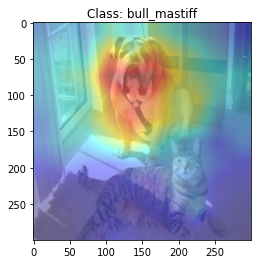

In [17]:
fig, ax = plt.subplots()
heatmap = saliency_map(tensor, cam)
ax.imshow(heatmap, cmap='turbo', alpha = 0.8)
ax.set_title(f"Class: {classes[idx]}")
# fig.savefig(f"/project/validating_attribution_techniques/saikat/Results/ScoreCAM/Original_image/{idx2label[idx]}.jpeg")

In [ ]:
#Creating the patch
PATCH_SIZE = 60
def apply_grey_patch(path, image, top_left_x, top_left_y, patch_size):
    patched_image = np.array(image, copy=True)
    patched_image[top_left_y:top_left_y + patch_size, top_left_x:top_left_x + patch_size, :] = 0
    img = keras.preprocessing.image.array_to_img(patched_image)
    print(path)
    img.save(path)
    print(np.shape(patched_image))
    return patched_image

In [ ]:
#Putting the patch over the image
image_path = "/project/validating_attribution_techniques/commons/examples/input.png"
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
image = tf.keras.preprocessing.image.img_to_array(image)

i = 0
# Iterate the patch over the image
for top_left_x in range(0, image.shape[0], PATCH_SIZE):
    for top_left_y in range(0, image.shape[1], PATCH_SIZE):
        # Apply the patch and display the image
        path = "/home/smitra/project/validating_attribution_techniques/saikat/Source_images/Occluded_images/occluded_img_" + str(i) + ".jpg"
        i+=1
        patched_image = apply_grey_patch(path,image, top_left_x, top_left_y, PATCH_SIZE)
        patched_image = patched_image.astype('float32') / 255.0
#         n_patched_image 

# Finding out number of Occluded Images generated

In [18]:
dir_path = "/home/shkulkar/project/validating_attribution_techniques/shardul/output/noisy_images/occlusion/"
count = 0
# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        count += 1
print('File count:', count)

File count: 16


# Metrics

In [19]:
import numpy as np
from skimage import img_as_float
from skimage import exposure

def normalize(x, method='standard', axis=None):
    '''Normalizes the input with specified method.

    Parameters
    ----------
    x : array-like
    method : string, optional
        Valid values for method are:
        - 'standard': mean=0, std=1
        - 'range': min=0, max=1
        - 'sum': sum=1
    axis : int, optional
        Axis perpendicular to which array is sliced and normalized.
        If None, array is flattened and normalized.

    Returns
    -------
    res : numpy.ndarray
        Normalized array.
    '''
    # TODO: Prevent divided by zero if the map is flat
    x = np.array(x, copy=False)
    if axis is not None:
        y = np.rollaxis(x, axis).reshape([x.shape[axis], -1])
        shape = np.ones(len(x.shape))
        shape[axis] = x.shape[axis]
        if method == 'standard':
            res = (x - np.mean(y, axis=1).reshape(shape)) / np.std(y, axis=1).reshape(shape)
        elif method == 'range':
            res = (x - np.min(y, axis=1).reshape(shape)) / (np.max(y, axis=1) - np.min(y, axis=1)).reshape(shape)
        elif method == 'sum':
            res = x / np.float_(np.sum(y, axis=1).reshape(shape))
        else:
            raise ValueError('method not in {"standard", "range", "sum"}')
    else:
        if method == 'standard':
            res = (x - np.mean(x)) / np.std(x)
        elif method == 'range':
            res = (x - np.min(x)) / (np.max(x) - np.min(x))
        elif method == 'sum':
            res = x / float(np.sum(x))
        else:
            raise ValueError('method not in {"standard", "range", "sum"}')
    return res


def match_hist(image, cdf, bin_centers, nbins=256):
    '''Modify pixels of input image so that its histogram matches target image histogram, specified by:
    cdf, bin_centers = cumulative_distribution(target_image)

    Parameters
    ----------
    image : array
        Image to be transformed.
    cdf : 1D array
        Values of cumulative distribution function of the target histogram.
    bin_centers ; 1D array
        Centers of bins of the target histogram.
    nbins : int, optional
        Number of bins for image histogram.

    Returns
    -------
    out : float array
        Image array after histogram matching.

    References
    ----------
    [1] Matlab implementation histoMatch(MTX, N, X) by Simoncelli, 7/96.
    '''
    image = img_as_float(image)
    old_cdf, old_bin = exposure.cumulative_distribution(image, nbins) # Unlike [1], we didn't add small positive number to the histogram
    new_bin = np.interp(old_cdf, cdf, bin_centers)
    out = np.interp(image.ravel(), old_bin, new_bin)
    return out.reshape(image.shape)

## 1. Similarity(SIM)

In [20]:
def SIM(saliency_map1, saliency_map2):
    '''
    Similarity between two different saliency maps when viewed as distributions
    (SIM=1 means the distributions are identical).

    This similarity measure is also called **histogram intersection**.

    Parameters
    ----------
    saliency_map1 : real-valued matrix
        If the two maps are different in shape, saliency_map1 will be resized to match saliency_map2.
    saliency_map2 : real-valued matrix

    Returns
    -------
    SIM : float, between [0,1]
    '''
    map1 = np.array(saliency_map1, copy=False)
    map2 = np.array(saliency_map2, copy=False)
    if map1.shape != map2.shape:
        map1 = resize(map1, map2.shape, order=3, mode='nearest') # bi-cubic/nearest is what Matlab imresize() does by default
    # Normalize the two maps to have values between [0,1] and sum up to 1
    map1 = normalize(map1, method='range')
    map2 = normalize(map2, method='range')
    map1 = normalize(map1, method='sum')
    map2 = normalize(map2, method='sum')
    # Compute histogram intersection
    intersection = np.minimum(map1, map2)
    return np.sum(intersection)

## 2. Pearson's Correlation Coefficient

In [21]:
def CC(saliency_map1, saliency_map2):
    '''
    Pearson's correlation coefficient between two different saliency maps
    (CC=0 for uncorrelated maps, CC=1 for perfect linear correlation).

    Parameters
    ----------
    saliency_map1 : real-valued matrix
        If the two maps are different in shape, saliency_map1 will be resized to match saliency_map2.
    saliency_map2 : real-valued matrix

    Returns
    -------
    CC : float, between [-1,1]
    '''
    map1 = np.array(saliency_map1, copy=False)
    map2 = np.array(saliency_map2, copy=False)
    if map1.shape != map2.shape:
        map1 = resize(map1, map2.shape, order=3, mode='nearest') # bi-cubic/nearest is what Matlab imresize() does by default
    # Normalize the two maps to have zero mean and unit std
    map1 = normalize(map1, method='standard')
    map2 = normalize(map2, method='standard')
    # Compute correlation coefficient
    return np.corrcoef(map1.ravel(), map2.ravel())[0,1]

## 3. Normalized Scanpath Saliency

In [22]:
def NSS(saliency_map, fixation_map):
    '''
    Normalized scanpath saliency of a saliency map,
    defined as the mean value of normalized (i.e., standardized) saliency map at fixation locations.
    You can think of it as a z-score. (Larger value implies better performance.)

    Parameters
    ----------
    saliency_map : real-valued matrix
        If the two maps are different in shape, saliency_map will be resized to match fixation_map..
    fixation_map : binary matrix
        Human fixation map (1 for fixated location, 0 for elsewhere).

    Returns
    -------
    NSS : float, positive
    '''
    s_map = np.array(saliency_map, copy=False)
    f_map = np.array(fixation_map, copy=False) > 0.5
    if s_map.shape != f_map.shape:
        s_map = resize(s_map, f_map.shape)
    # Normalize saliency map to have zero mean and unit std
    s_map = normalize(s_map, method='standard')
    # Mean saliency value at fixation locations
    return np.mean(s_map[f_map])

## 4. Area Under ROC Curve

In [23]:
def AUC_Judd(saliency_map, fixation_map, jitter=True):
    '''
    AUC stands for Area Under ROC Curve.
    This measures how well the saliency map of an image predicts the ground truth human fixations on the image.

    ROC curve is created by sweeping through threshold values
    determined by range of saliency map values at fixation locations.
    True positive (tp) rate correspond to the ratio of saliency map values above threshold
    at fixation locations to the total number of fixation locations.
    False positive (fp) rate correspond to the ratio of saliency map values above threshold
    at all other locations to the total number of possible other locations (non-fixated image pixels).

    AUC=0.5 is chance level.

    Parameters
    ----------
    saliency_map : real-valued matrix
    fixation_map : binary matrix
        Human fixation map.
    jitter : boolean, optional
        If True (default), a small random number would be added to each pixel of the saliency map.
        Jitter saliency maps that come from saliency models that have a lot of zero values.
        If the saliency map is made with a Gaussian then it does not need to be jittered
        as the values vary and there is not a large patch of the same value.
        In fact, jittering breaks the ordering in the small values!

    Returns
    -------
    AUC : float, between [0,1]
    '''
    saliency_map = np.array(saliency_map, copy=False)
    fixation_map = np.array(fixation_map, copy=False) > 0.5
    # If there are no fixation to predict, return NaN
    if not np.any(fixation_map):
        print('no fixation to predict')
        return np.nan
    # Make the saliency_map the size of the fixation_map
    if saliency_map.shape != fixation_map.shape:
        saliency_map = resize(saliency_map, fixation_map.shape, order=3, mode='nearest')
    # Jitter the saliency map slightly to disrupt ties of the same saliency value
    if jitter:
        saliency_map += random.rand(*saliency_map.shape) * 1e-7
    # Normalize saliency map to have values between [0,1]
    saliency_map = normalize(saliency_map, method='range')

    S = saliency_map.ravel()
    F = fixation_map.ravel()
    S_fix = S[F] # Saliency map values at fixation locations
    n_fix = len(S_fix)
    n_pixels = len(S)
    # Calculate AUC
    thresholds = sorted(S_fix, reverse=True)
    tp = np.zeros(len(thresholds)+2)
    fp = np.zeros(len(thresholds)+2)
    tp[0] = 0; tp[-1] = 1
    fp[0] = 0; fp[-1] = 1
    for k, thresh in enumerate(thresholds):
        above_th = np.sum(S >= thresh) # Total number of saliency map values above threshold
        tp[k+1] = (k + 1) / float(n_fix) # Ratio saliency map values at fixation locations above threshold
        fp[k+1] = (above_th - k - 1) / float(n_pixels - n_fix) # Ratio other saliency map values above threshold
    return np.trapz(tp, fp) # y, x


def AUC_Borji(saliency_map, fixation_map, n_rep=100, step_size=0.1, rand_sampler=None):
    '''
    This measures how well the saliency map of an image predicts the ground truth human fixations on the image.

    ROC curve created by sweeping through threshold values at fixed step size
    until the maximum saliency map value.
    True positive (tp) rate correspond to the ratio of saliency map values above threshold
    at fixation locations to the total number of fixation locations.
    False positive (fp) rate correspond to the ratio of saliency map values above threshold
    at random locations to the total number of random locations
    (as many random locations as fixations, sampled uniformly from fixation_map ALL IMAGE PIXELS),
    averaging over n_rep number of selections of random locations.

    Parameters
    ----------
    saliency_map : real-valued matrix
    fixation_map : binary matrix
        Human fixation map.
    n_rep : int, optional
        Number of repeats for random sampling of non-fixated locations.
    step_size : int, optional
        Step size for sweeping through saliency map.
    rand_sampler : callable
        S_rand = rand_sampler(S, F, n_rep, n_fix)
        Sample the saliency map at random locations to estimate false positive.
        Return the sampled saliency values, S_rand.shape=(n_fix,n_rep)

    Returns
    -------
    AUC : float, between [0,1]
    '''
    saliency_map = np.array(saliency_map, copy=False)
    fixation_map = np.array(fixation_map, copy=False) > 0.5
    # If there are no fixation to predict, return NaN
    if not np.any(fixation_map):
        print('no fixation to predict')
        return np.nan
    # Make the saliency_map the size of the fixation_map
    if saliency_map.shape != fixation_map.shape:
        saliency_map = resize(saliency_map, fixation_map.shape, order=3, mode='nearest')
    # Normalize saliency map to have values between [0,1]
    saliency_map = normalize(saliency_map, method='range')

    S = saliency_map.ravel()
    F = fixation_map.ravel()
    S_fix = S[F] # Saliency map values at fixation locations
    n_fix = len(S_fix)
    n_pixels = len(S)
    # For each fixation, sample n_rep values from anywhere on the saliency map
    if rand_sampler is None:
        r = random.randint(0, n_pixels, [n_fix, n_rep])
        S_rand = S[r] # Saliency map values at random locations (including fixated locations!? underestimated)
    else:
        S_rand = rand_sampler(S, F, n_rep, n_fix)
    # Calculate AUC per random split (set of random locations)
    auc = np.zeros(n_rep) * np.nan
    for rep in range(n_rep):
        thresholds = np.r_[0:np.max(np.r_[S_fix, S_rand[:,rep]]):step_size][::-1]
        tp = np.zeros(len(thresholds)+2)
        fp = np.zeros(len(thresholds)+2)
        tp[0] = 0; tp[-1] = 1
        fp[0] = 0; fp[-1] = 1
        for k, thresh in enumerate(thresholds):
            tp[k+1] = np.sum(S_fix >= thresh) / float(n_fix)
            fp[k+1] = np.sum(S_rand[:,rep] >= thresh) / float(n_fix)
        auc[rep] = np.trapz(tp, fp)
    return np.mean(auc) # Average across random splits

# Wasserstein distance

In [24]:
def wasserstein_distance(cam, perturbed_cam):
    saliency_map1 = np.array(cam.reshape(90000))
    saliency_map2 = np.array(perturbed_cam.reshape(90000))

#     print(saliency_map1.shape)
#     print(saliency_map1)
    emd = sci.wasserstein_distance(saliency_map1, saliency_map2) 
    return emd

In [25]:
#Calling all metrics in one
def calculate_metrics(cam, perturbed_cam):
    sim = SIM(cam, perturbed_cam)
    cc = CC(cam, perturbed_cam)
    nss = NSS(cam, perturbed_cam)
    auc_judd = AUC_Judd(cam, perturbed_cam)
    auc_borji = AUC_Borji(cam, perturbed_cam)
    emd = wasserstein_distance(cam, perturbed_cam)
    return sim, cc, nss, auc_judd, auc_borji, emd

# ScoreCAM on Occluded Images

Iteration 0 of / 16
Similarity:  0.9017682 
Pearson Correlation:  0.9374057430053313 
Normalized Scanpath saliency:  1.754856 
AUC_Judd:  0.9933322341614282 
AUC_Borji:  0.9120277899946381 
EMD:  0.045049926002499435
Iteration 1 of / 16
Similarity:  0.89604986 
Pearson Correlation:  0.9313637138150269 
Normalized Scanpath saliency:  1.7053553 
AUC_Judd:  0.9949228663608892 
AUC_Borji:  0.9063937706206725 
EMD:  0.045787161979486304
Iteration 2 of / 16
Similarity:  0.9177294 
Pearson Correlation:  0.9578671679561731 
Normalized Scanpath saliency:  1.7153 
AUC_Judd:  0.9951097324612157 
AUC_Borji:  0.9077243859145833 
EMD:  0.03486607381992246
Iteration 3 of / 16
Similarity:  0.93646944 
Pearson Correlation:  0.9787636875256681 
Normalized Scanpath saliency:  1.7279938 
AUC_Judd:  0.9967618406292021 
AUC_Borji:  0.9095846525886507 
EMD:  0.031072226992851767
Iteration 4 of / 16
Similarity:  0.45537055 
Pearson Correlation:  -0.19365007752957966 
Normalized Scanpath saliency:  -0.3869613 

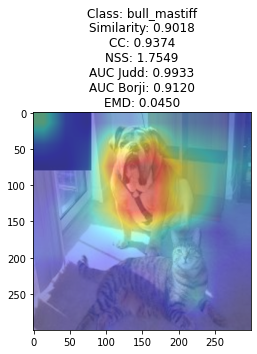

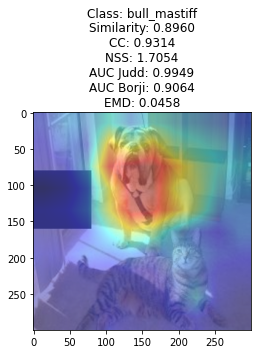

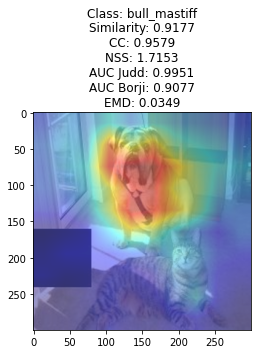

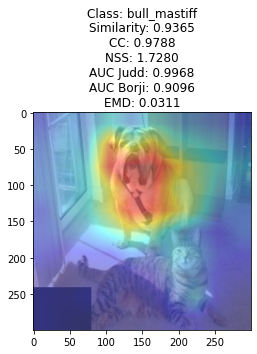

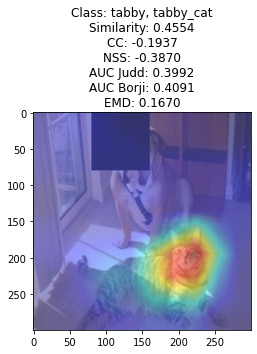

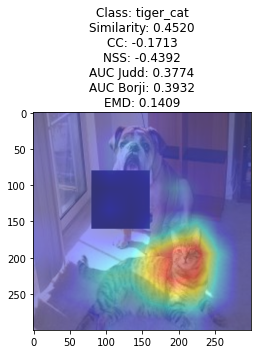

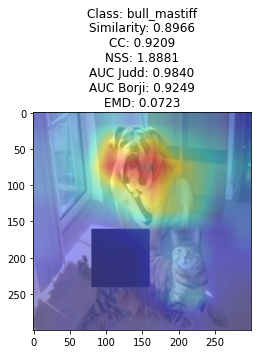

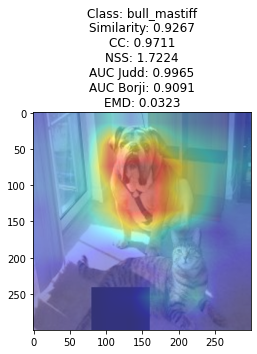

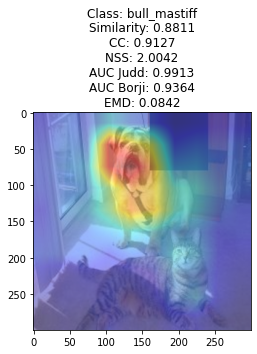

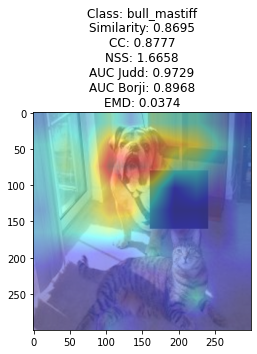

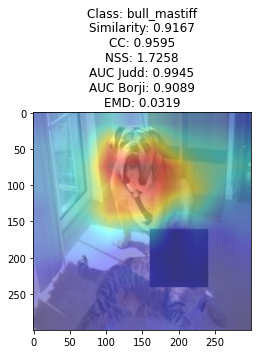

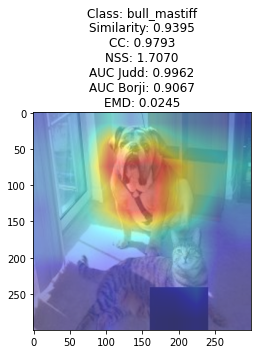

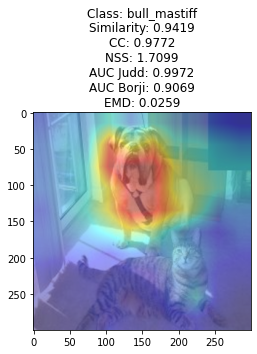

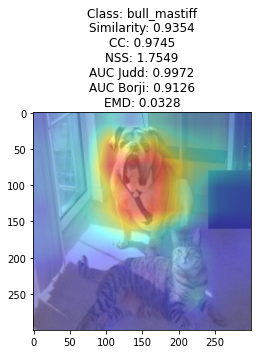

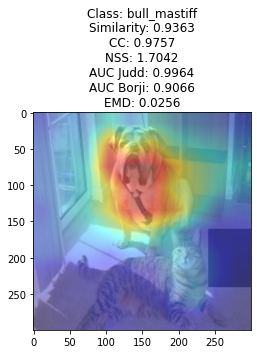

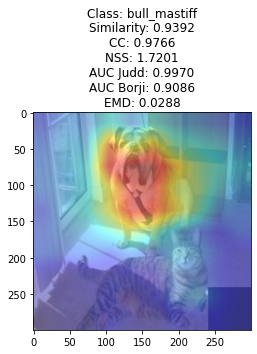

In [26]:
# fig, ax = plt.subplots()

for i in range(0,count):
    fig, ax = plt.subplots()
    img = tf.keras.preprocessing.image.load_img("/home/shkulkar/project/validating_attribution_techniques/shardul/output/noisy_images/occlusion/occluded_img_" + str(i) + ".jpg")
    perturbed_tensor = preprocessing(img) # calling the preprocessing function
    gpu_reference_tensor = next(model.parameters())
    perturbed_tensor = perturbed_tensor.type_as(gpu_reference_tensor)
    perturbed_cam, perturbed_idx = scoreCAM(target_layer, model, perturbed_tensor)
    perturbed_cam = perturbed_cam.cpu()
    sim, cc, nss, auc_judd, auc_borji, emd= calculate_metrics(cam, perturbed_cam)
    print("Iteration", i , "of /", count)
    print("Similarity: ",sim,"\nPearson Correlation: ",cc,"\nNormalized Scanpath saliency: ",nss,"\nAUC_Judd: ", auc_judd, "\nAUC_Borji: ",auc_borji, "\nEMD: ", emd)
#     fig, ax = plt.subplots()
#     ax.imshow(image_array, cmap = 'turbo', alpha = 0.8)
#     fig.savefig(f"/project/validating_attribution_techniques/juneja/output/noisy_images/{i}_noise.jpeg")
#     print(idx)
#     print(idx2label[idx])
    perturbed_heatmap = saliency_map(perturbed_tensor, perturbed_cam)
    ax.imshow(perturbed_heatmap, cmap='turbo', alpha = 0.8)
#     ax.set_title(f"Class: {classes[perturbed_idx]}")
    ax.set_title(f"Class: {classes[perturbed_idx]}\nSimilarity: {sim:.4f}\nCC: {cc:.4f}\nNSS: {nss:.4f}\nAUC Judd: {auc_judd:.4f}\nAUC Borji: {auc_borji:.4f}\nEMD: {emd:.4f}")
    fig.savefig(f"/home/shkulkar/project/validating_attribution_techniques/shardul/output/Results/ScoreCAM/Occluded_images/{i}_{classes[perturbed_idx]}.jpg")
    
plt.show()